In [1]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
from cellpose import utils, io, models, plot
from pathlib import Path

100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 21.13it/s]


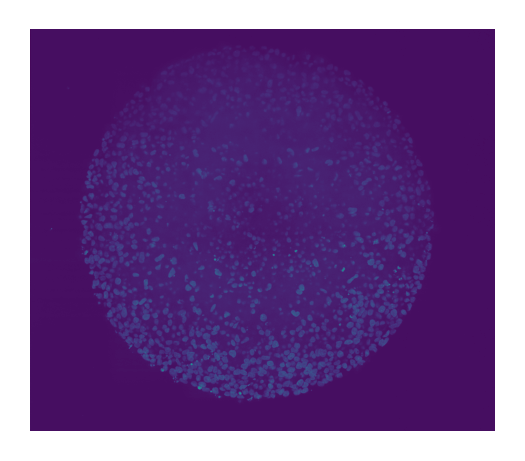

m = 2450, n = 2835, nzslices = 37



In [8]:
# get a list of files to segment
dataDir = Path(os.getcwd())

nucChannel = 0 #nuclear channel
files = []
for filename in Path(dataDir).rglob("stitched_p*_w%.4d_t0000.tif" % nucChannel):
    filepath = os.path.split(filename)[0]
    if filepath == str(dataDir):
        files.append(filename)
    #print(filename)

# view 1 image
img = io.imread(files[0])
nzslices = img.shape[0] #number of z slices
m = img.shape[1]
n = img.shape[2]
plt.figure(figsize=(2,2))
#look at z slice 4
plt.imshow(img[4,:,:])
plt.axis('off')
plt.show()
print('m = %d, n = %d, nzslices = %d\n' % (m,n,nzslices))

In [3]:
def rescale_intensity(im,p1,p99):
    #function to rescale image intensity values based on maximum and minimum percentiles
    #images are converted to floats with intensity values in the range (0,1)
    im[im<p1] = p1
    im[im>p99] = p99
    imnew = (im - p1)/(p99 - p1)
    return imnew


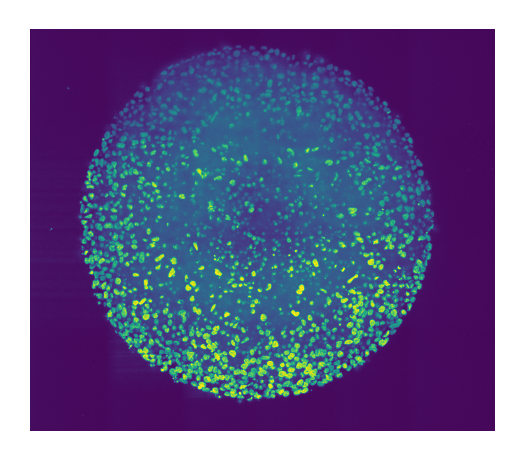

In [4]:
#display image with rescaled + saturated intensity
#from skimage import exposure
im = img[4,:,:]
p1, p99 = np.percentile(im, (1, 99))
J = rescale_intensity(im, p1, p99)

plt.figure(figsize=(2,2))
plt.imshow(J)
plt.axis('off')
plt.show()

In [5]:
#run the model once
#if you set diameter=None in the call to model.eval, it will run the model once to estimate the size of nuclei and run again
#to do actual segmentation but this is slow and works less well on the micropattern than on sparser disordered cells
#I generally estimate in Fiji instead; for 40x, nuclear diameter generally ranges from ~25-70 pixels (~8-22 um)
model = models.Cellpose(gpu=False, model_type='nuclei')
chan = [0,0] #use chan = [0,0] for nuclear segmentation only
diam = 35

im = img[4,:,:]
p1, p99 = np.percentile(im, (1, 99))
J = rescale_intensity(im, p1,p99)
masks, flows, styles, diams = model.eval(J, diameter=diam, channels=chan, net_avg=True)

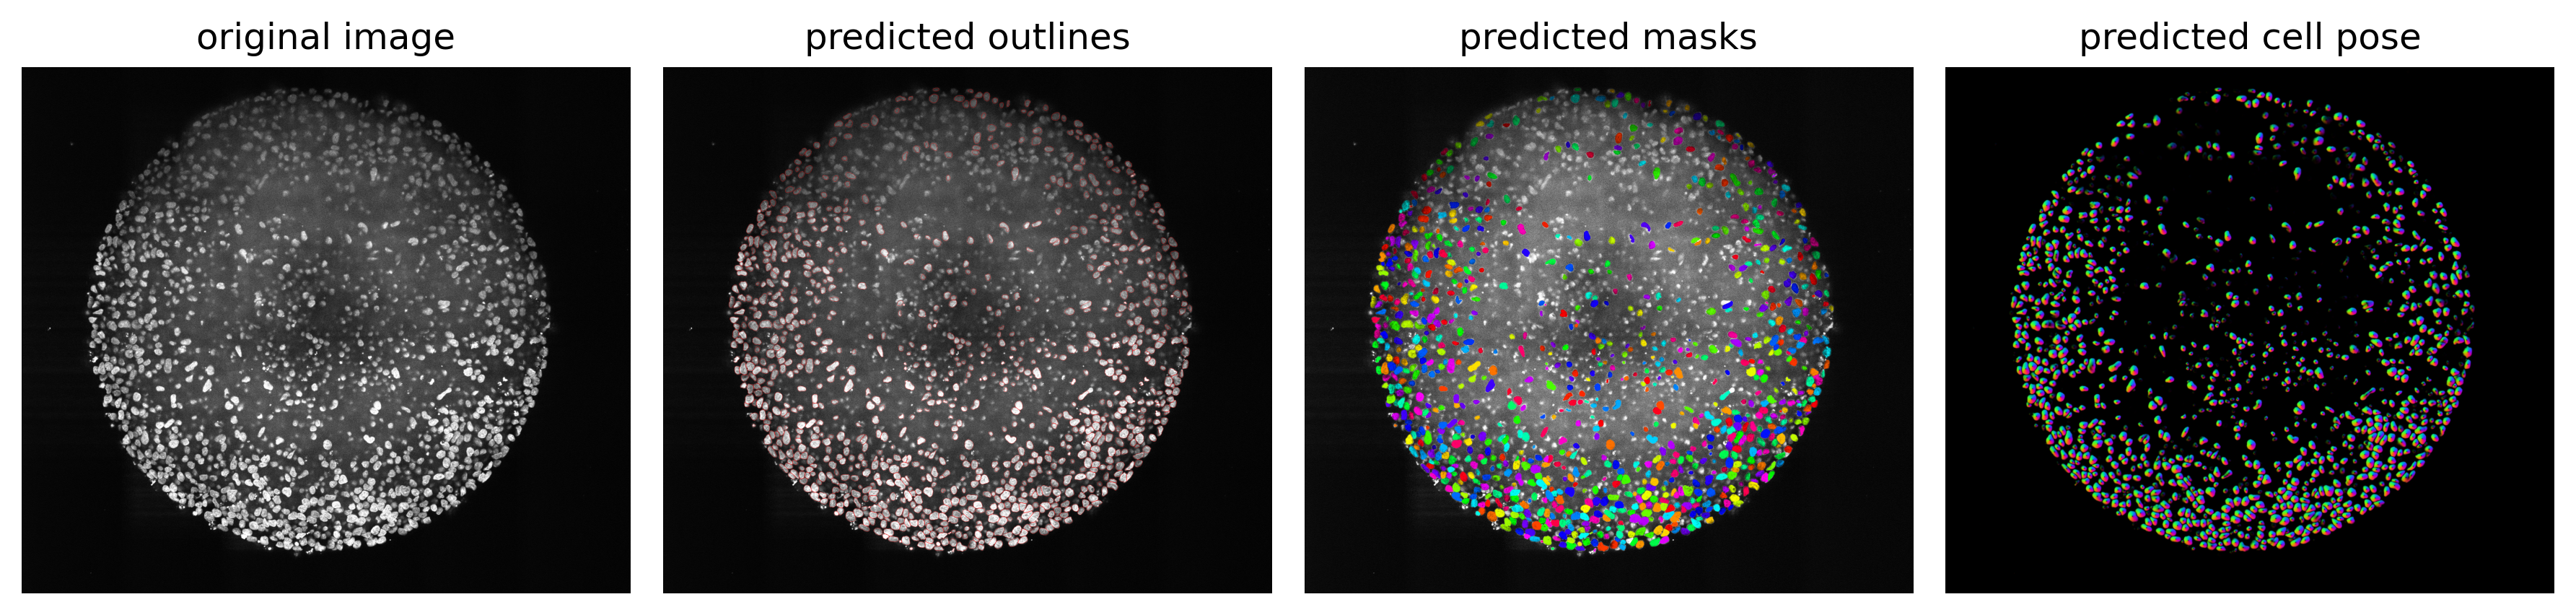

In [6]:
# DISPLAY RESULTS
#The built-in way of doing this is extremely slow, I've been saving results and visualizing in matlab instead
fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, J, masks, flows[0], channels=chan)
plt.tight_layout()
plt.show()

In [7]:
# RUN CELLPOSE

# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=False, model_type='nuclei')
chan = [0,0]


# process files and z slices in a loop
for filename in files:
    base = os.path.splitext(filename)[0]
    print(base)
    img = io.imread(filename)
    nzslices = img.shape[0]
    for zi in range(0,nzslices):
        im = img[zi,:,:]
        p1, p99 = np.percentile(im, (1, 99))
        J = rescale_intensity(im,p1,p99)
        masks, flows, styles, diams = model.eval(J, diameter=diam, channels=chan, net_avg=True)
        # save results as png
        masks = masks.astype(np.uint16) if masks.max()<2**16-1 else masks.astype(np.uint32)
        io.imsave(base + '_z%.4d' % zi + '_cp_masks.png', masks)
    

C:\Users\teaguest\Desktop\6i_protocols_test\code\data\230110_6i9rd_exp20_RD1_SMAD23_pAKT_SOX17\stitched_p0000_w0000_t0000


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 34.71it/s]


C:\Users\teaguest\Desktop\6i_protocols_test\code\data\230110_6i9rd_exp20_RD1_SMAD23_pAKT_SOX17\stitched_p0000_w0000_t0000_cp_masks


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 40.96it/s]
C:\Users\teaguest\AppData\Local\Temp\ipykernel_2512\3357571782.py:6: RuntimeWarning: invalid value encountered in divide
  imnew = (im - p1)/(p99 - p1)


C:\Users\teaguest\Desktop\6i_protocols_test\code\data\230110_6i9rd_exp20_RD1_SMAD23_pAKT_SOX17\stitched_p0000_w0000_t0000_FinalSegmentation


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 39.60it/s]
